# Calculate Group Statistics.
Has Functions to calculate Fractions per Population Group.
- Calculate uncertainties per Group
- Save them as Pandas Dataframe
- Modify Pandas Data
- Save as .csv

In [1]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt

### Do the Arial 
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the default
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./Python3/")  # Since now we are in the Root Directory
from statsmodels.stats.proportion import proportion_confint  # Estimate Binomial proportion Confidence Intervalls

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

VioletQueen
/home/harald/git/HAPSBURG
CPU Count: 4


### Helper Functions

In [12]:
def cutoff_statistic_perpop(df, cutoff= 70, col="statistic", round_dgts=3,
                            method="wilson", groupby="pop", sort=True, bigger=True):
    """Calculate Cutoff Statistics per Group 
    and return summary dataframe with unctertainty.
    method: Which Method to use for binomial uncertainty fractions
    groupby: What colum(s) to group by (can be list).
    bigger: Whether to count values bigger than the cutoff"""
    if bigger:
        df[f"statistic>{cutoff}"] = (df[col] >= cutoff)
    else:
        df[f"statistic>{cutoff}"] = (df[col] <= cutoff)
        
    df_mg = df.groupby(groupby, sort=False) # Sort by First Occurence
    df_pop_stat = df_mg[f"statistic>{cutoff}"].agg(["sum", 'count']).astype("int")
    df_pop_stat["frac"] = df_pop_stat["sum"]/df_pop_stat["count"]
    if sort:
        df_pop_stat = df_pop_stat.sort_values(by="frac", ascending=False)  # Sort for better output
    df_pop_stat = estimate_ci_fractions(df_pop_stat, col_c="sum", col_n="count", method=method)
    df_pop_stat = df_pop_stat.round(round_dgts)
    return df_pop_stat.reset_index()

def estimate_ci_fractions(df, col_c="sum", col_n="count", method="wilson"):
    """Estimate Confidence Intervals from Binomial Fractions.
    Add these fractions as two new columns to data frame
    (frac_low, frac_high) and return dataframe
    df: Dataframe to use
    col_c: Count Column
    col_n Total Count Column
    method: Which binomial proportion confidence interval to use"""
    c, n = df[col_c].values, df[col_n].values
    low, high = proportion_confint(c,n,method=method)
    df["frac_low"], df["frac_high"] = low, high
    return df

def calc_statistic(df, frac=0.65, cm = [4,8,12] ):
    """Calculate the "statistic" from cutoff.
    cm: Cutoffs [in centiMorgan]
    frac: Fraction of the lower category to substract"""
    statistic = df[f"sum_roh>{cm[2]}"] - frac * ((df[f"sum_roh>{cm[0]}"]) - df[f"sum_roh>{cm[1]}"])
    return statistic

def plot_bars_fractions(df, col="frac", col_l="frac_low", col_h="frac_high", xticks=[],
                        figsize=(18,5), bar_width=0.9, fs_l=7, ec="k", c="coral", legend=True,
                        savepath=""):
    """Plot Fractions in dataframe df. 
    col: Which column has values
    col_l, col_h: Values for low & high CIs"""

    x = np.arange(len(df))
    y = df[col].values

    plt.figure(figsize=figsize)
    ax=plt.gca()
    ax.bar(x, y, width = bar_width, color = c, edgecolor = ec)
    # yerr=[df_t["frac_low"], df_t["frac_high"]]

    # general layout
    ax.set_xticks(x)
    ax.set_xticklabels(xticks, rotation=90, fontsize=fs_l)
    ax.set_xlim([-0.5,np.max(x)+0.5])
    ax.set_ylim([0,1])
    ax.set_ylabel("Fraction Individuals with Statistic > 70")
    ax.vlines(x, df[col_l], df[col_h], lw=0.5, label="95% CI Intervalls")
    if legend:
        ax.legend(loc="upper right")
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
    plt.show()

# Cousin Statistic

## Modern HO Populations

In [40]:
df = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
statistic = calc_statistic(df)
df["statistic"] = statistic
df = df[df["age"]==0].copy()   ### Extract Modern Samples
df_t = cutoff_statistic_perpop(df, cutoff=70)

Saved to ./figures_test/bar_stat/bar_stat_modern.pdf


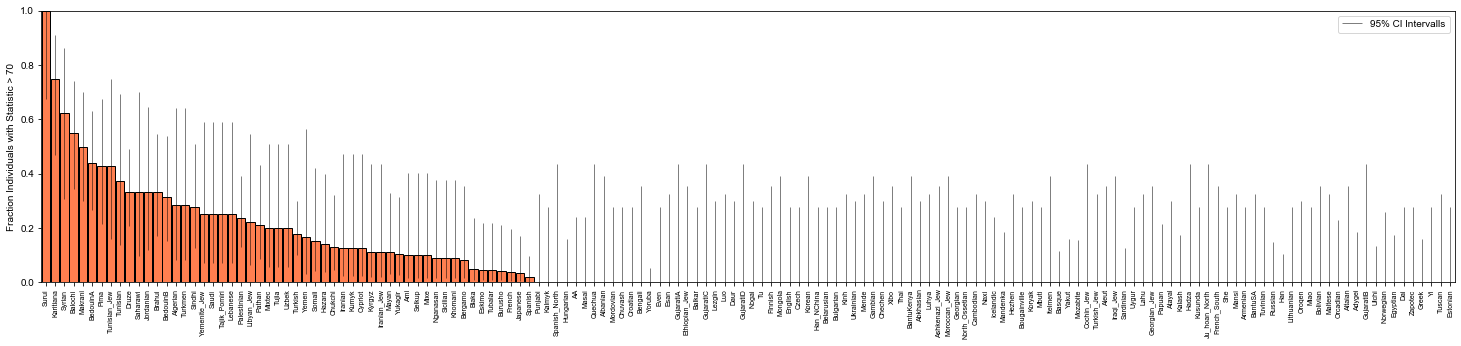

In [42]:
### Plot Results
df_plot = df_t[df_t["count"]>=5].copy()
plot_bars_fractions(df_plot, col="frac", xticks=df_plot["pop"],
                    col_l='frac_low', col_h='frac_high', figsize=(len(df_plot)/6, 5),
                   savepath="./figures_test/bar_stat/bar_stat_modern.pdf")
df_ho = df_t

## Ancient Individuals

### Over all Periods

Saved to ./figures_test/bar_stat/bar_stat_ancient.pdf


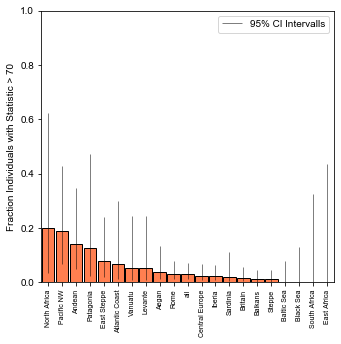

In [23]:
df = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df = df[df["age"]>0].copy()   ### Extract Ancient Samples
statistic = calc_statistic(df)
df["statistic"] = statistic

df_t = cutoff_statistic_perpop(df, cutoff=70, col="statistic", groupby="region")
df_plot = df_t[df_t["count"]>=5]
plot_bars_fractions(df_plot, col="frac", col_l='frac_low', figsize=(len(df_plot)/4, 5),
                    col_h='frac_high', xticks=df_plot["region"],
                   savepath="./figures_test/bar_stat/bar_stat_ancient.pdf")

### Broken up into Mesolithic/Neolithic/Early Neolithic

In [38]:
df = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df = df[df["age"]>0].copy()   ### Extract Ancient Samples
statistic = calc_statistic(df)
df["statistic"] = statistic
period = ["Mesolithic", "Neolithic", "Early Neolithic"]
idx = df["clst"].isin(period)
print(f"Extracting {np.sum(idx)} Individuals in {period}")
df = df[idx].copy()
df = df.sort_values(['region', 'age'], ascending=False) # Sort so that groupby is in order (age)

Extracting 352 Individuals in ['Mesolithic', 'Neolithic', 'Early Neolithic']


Saved to ./figures_test/bar_stat/bar_stat_meso_neo_europe.pdf


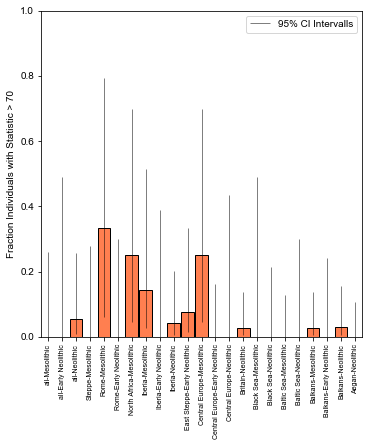

In [39]:
df_t = cutoff_statistic_perpop(df, cutoff=70, col="statistic", groupby=["region", "clst"], sort=False)
df_plot = df_t[df_t["count"]>=3]
plot_bars_fractions(df_plot, col="frac", col_l='frac_low', col_h='frac_high',
                   figsize=(len(df_plot)/4, 6), xticks=df_plot["region"]+ "-" + df_plot["clst"],
                   savepath="./figures_test/bar_stat/bar_stat_meso_neo_europe.pdf")
df_eu_anc = df_plot

### Split up South American Ancients

In [36]:
df = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df = df[df["age"]>0].copy()   ### Extract Ancient Samples
statistic = calc_statistic(df)
df["statistic"] = statistic
regions = ["Pacific NW", "Andean", "Patagonia", "Atlantic Coast"]
idx = df["region"].isin(regions)
print(f"Extracting {np.sum(idx)} Individuals in {regions}")
df = df[idx].copy()
df = df.sort_values('region', ascending=True) # Sort so that groupby is in alphabetical

Extracting 60 Individuals in ['Pacific NW', 'Andean', 'Patagonia', 'Atlantic Coast']


Saved to ./figures_test/bar_stat/bar_stat_sa.pdf


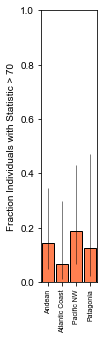

In [37]:
df_t = cutoff_statistic_perpop(df, cutoff=70, col="statistic", groupby="region", sort=False)
df_plot = df_t[df_t["count"]>=3]
plot_bars_fractions(df_plot, col="frac", col_l='frac_low', col_h='frac_high', xticks=df_plot["region"], 
                    figsize=(len(df_plot)/4, 5), legend=False,
                    savepath="./figures_test/bar_stat/bar_stat_sa.pdf")
df_sa_anc = df_plot

# Ancients from Vanuatu, East & South Africa

In [43]:
df = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df = df[df["age"]>0].copy()   ### Extract Ancient Samples
statistic = calc_statistic(df)
df["statistic"] = statistic
regions = ["Vanuatu", "East Africa", "South Africa"]
idx = df["region"].isin(regions)
print(f"Extracting {np.sum(idx)} Individuals in {regions}")
df = df[idx].copy()
df = df.sort_values('region', ascending=True) # Sort so that groupby is in alphabetical

Extracting 32 Individuals in ['Vanuatu', 'East Africa', 'South Africa']


Saved to ./figures_test/bar_stat/bar_stat_gl.pdf


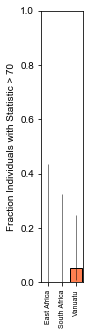

In [44]:
df_t = cutoff_statistic_perpop(df, cutoff=70, col="statistic", groupby="region", sort=False)
df_plot = df_t[df_t["count"]>=3]
plot_bars_fractions(df_plot, col="frac", col_l='frac_low', col_h='frac_high', xticks=df_plot["region"], 
                    figsize=(len(df_plot)/4, 5), legend=False, savepath="./figures_test/bar_stat/bar_stat_gl.pdf")
df_rest_anc = df_plot

# Combine and produce Latex Code for Tables Paper

In [73]:
out = df_eu_anc.to_latex(header=False, index=False)
print(out)

\begin{tabular}{llrrrrr}
\toprule
            all &       Mesolithic &  0 &  11 &  0.000 &  0.000 &  0.259 \\
            all &  Early Neolithic &  0 &   4 &  0.000 &  0.000 &  0.490 \\
            all &        Neolithic &  1 &  18 &  0.056 &  0.010 &  0.258 \\
         Steppe &       Mesolithic &  0 &  10 &  0.000 &  0.000 &  0.278 \\
           Rome &       Mesolithic &  1 &   3 &  0.333 &  0.061 &  0.792 \\
           Rome &  Early Neolithic &  0 &   9 &  0.000 &  0.000 &  0.299 \\
   North Africa &       Mesolithic &  1 &   4 &  0.250 &  0.046 &  0.699 \\
         Iberia &       Mesolithic &  1 &   7 &  0.143 &  0.026 &  0.513 \\
         Iberia &  Early Neolithic &  0 &   6 &  0.000 &  0.000 &  0.390 \\
         Iberia &        Neolithic &  1 &  24 &  0.042 &  0.007 &  0.202 \\
    East Steppe &  Early Neolithic &  1 &  13 &  0.077 &  0.014 &  0.333 \\
 Central Europe &       Mesolithic &  1 &   4 &  0.250 &  0.046 &  0.699 \\
 Central Europe &  Early Neolithic &  0 &  20 &  0.000

In [143]:
outpops = ["Makrani", "Palestinian", "Pathan", "Tunisian", "Biaka", "Yakut",
                            "French", "Han", "Masai", "Syrian", "BedouinA"]
df_out = df_ho[df_ho["pop"].isin(outpops)]
df_out.insert (1, "Period", "modern") # Insert Modern Label
out = df_out.to_latex(header=False, index=False)
print(out)

\begin{tabular}{llrrrrr}
\toprule
      Syrian &  modern &   5 &   8 &  0.625 &  0.306 &  0.863 \\
     Makrani &  modern &  10 &  20 &  0.500 &  0.299 &  0.701 \\
    BedouinA &  modern &  11 &  25 &  0.440 &  0.267 &  0.629 \\
    Tunisian &  modern &   3 &   8 &  0.375 &  0.137 &  0.694 \\
 Palestinian &  modern &   9 &  38 &  0.237 &  0.130 &  0.392 \\
      Pathan &  modern &   4 &  19 &  0.211 &  0.085 &  0.433 \\
       Biaka &  modern &   1 &  20 &  0.050 &  0.009 &  0.236 \\
      French &  modern &   1 &  25 &  0.040 &  0.007 &  0.195 \\
       Masai &  modern &   0 &  12 &  0.000 &  0.000 &  0.242 \\
       Yakut &  modern &   0 &  20 &  0.000 &  0.000 &  0.161 \\
         Han &  modern &   0 &  33 &  0.000 &  0.000 &  0.104 \\
\bottomrule
\end{tabular}



## Combine and save .csvs

In [ ]:
df_ho.insert (1, "clst", "modern") # Insert Modern Label
df_ho.rename(columns={'pop':'region'}, inplace=True)
df_ho

In [ ]:
df_sa_anc.insert(1, "clst", "all") # Insert Modern Label
df_sa_anc
#pd.concat([df_sa_anc, df_rest_anc])

In [170]:
df_rest_anc.insert (1, "clst", "all") # Insert Modern Label

In [171]:
dfs = [df_sa_anc, df_rest_anc, df_eu_anc, df_ho]
df_all = pd.concat(dfs)

In [174]:
savepath = "./TablesOut/fractions_stat>70.csv"
df_all.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(df_all)} Pops to {savepath}")

Saved 192 Pops to ./TablesOut/fractions_stat>70.csv


# Calculate 0 Fractions

# Area 51

In [93]:
df = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')

In [100]:
df_t = df[(df["region"]=="Black Sea") & (df["clst"]=="Neolithic")]